# Loading the libraries

In [1]:
import pandas as pd
import numpy as np
import itertools

#using pulp library for linear programming
from pulp import *

from IPython.core.display import display, HTML

def display_(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


import warnings
warnings.filterwarnings("ignore")

In [159]:
import matplotlib.pyplot as plot
import seaborn as sns

# Load the dataset

In [2]:
target_hours_per_week = pd.read_excel("OT Scheduling.xlsx", sheet_name="Target Hours per Week")
target_hours_per_week.set_index(["Department"], inplace=True)


teams_available_per_week = pd.read_excel("OT Scheduling.xlsx", sheet_name="Available teams per week")
teams_available_per_week.set_index(["Department"], inplace=True)


max_daily_OT_requirement = pd.read_excel("OT Scheduling.xlsx", sheet_name="Max Daily OT requirements")
max_daily_OT_requirement.set_index(["Department"], inplace=True)


weekly_OT_requirement = pd.read_excel("OT Scheduling.xlsx", sheet_name="Weekly OT requirements")
weekly_OT_requirement.set_index(["Department"], inplace=True)

In [3]:
display_(
    
    dfs=[target_hours_per_week, 
         teams_available_per_week,
         max_daily_OT_requirement], 
    
    captions=["Target Hours Per Week",
              "Teams Available Per Week", 
              "Maximum Daily OT requirement"])

<AxesSubplot:xlabel='Department'>

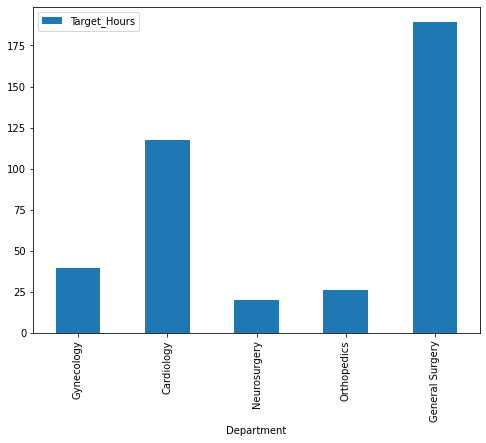

In [11]:
#target_hours_per_week.Department.value_counts().plot(kind='bar')
target_hours_per_week.plot(kind="bar", figsize = (8, 6))

<AxesSubplot:xlabel='Department'>

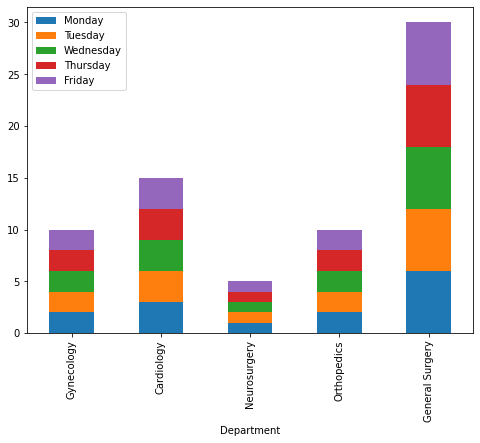

In [12]:
teams_available_per_week.plot(kind="bar", figsize = (8, 6), stacked = True)

<AxesSubplot:xlabel='Department'>

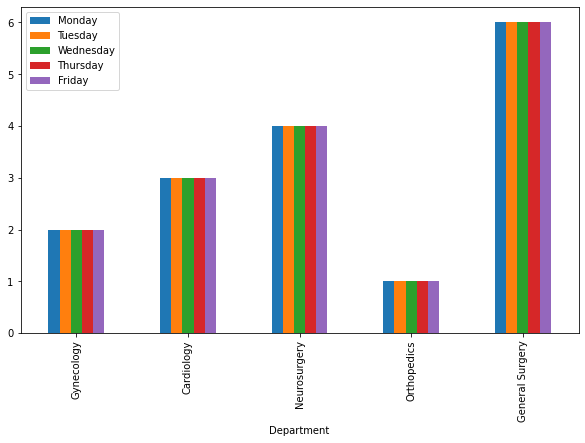

In [14]:
max_daily_OT_requirement.plot(kind="bar", figsize = (10, 6))

# Decision variables

In [42]:
teams = teams_available_per_week.index.to_list()
day_of_week = teams_available_per_week.columns.to_list()

var_dict = LpVariable.dicts("Allotment",
                            [(dept, day) for dept in teams for day in day_of_week], 
                            lowBound = 0, 
                            cat = "Integer")

# Initializing the model

In [43]:
model = LpProblem("Optimized Allocation of Hospital Operating Theatres", LpMaximize)


# Objective function

In [44]:
model += lpSum([8*var_dict[(team,days)]/target_hours_per_week.loc[team, "Target_Hours"]\
                for team in teams for days in day_of_week])

# Constraints

In [45]:
#Constraint-1 At most 10 OTs can be assigned per day
for day in day_of_week:
    model += lpSum([var_dict[(team, day)] for team in teams]) <= 10



#Constraint-2 The number of ORs allocaed to a department on that day cannot exceed the number of surgery teams available that day
for team in teams:
    for day in day_of_week:
        model += var_dict[(team, day)] <= teams_available_per_week.loc[team, day]

        
    
#Constraint-3 Meet daily minimums and maximums of each department
for team in teams:
    for day in day_of_week:
        model += var_dict[(team, day)] <= max_daily_OT_requirement.loc[team, day]

                
# Constraint-4 Meet weekly minimums and maximums of each department
#for team in teams:
#    model += lpSum([var_dict[(team, day)] for day in day_of_week]) >= weekly_OT_requirement.loc[team, "Minimum"]
#  model += lpSum([var_dict[(team, day)] for day in day_of_week]) <= weekly_OT_requirement.loc[team, "Maximum"]

# Find Optimal solution

In [129]:
model.solve()

if LpStatus[model.status]=="Optimal":
    optimal_soln = pd.DataFrame([(v.name, int(v.varValue)) for v in model.variables() if v.varValue!=0],
                                columns=["Decisions", "# OTs Allocated"])

In [130]:
optimal_soln
optimal_soln1 = optimal_soln
optimal_soln1.insert(1, "Day", ['Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday',
                                'Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday',
                                'Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday',
                                'Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday',
                                'Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday'], True)


In [131]:
optimal_soln1


,Decisions,Day,# OTs Allocated
0,"Allotment_('Cardiology',_'Friday')",Friday,3
1,"Allotment_('Cardiology',_'Monday')",Monday,3
2,"Allotment_('Cardiology',_'Thursday')",Thursday,3
3,"Allotment_('Cardiology',_'Tuesday')",Tuesday,3
4,"Allotment_('Cardiology',_'Wednesday')",Wednesday,3
5,"Allotment_('General_Surgery',_'Friday')",Friday,3
6,"Allotment_('General_Surgery',_'Monday')",Monday,3
7,"Allotment_('General_Surgery',_'Thursday')",Thursday,3
8,"Allotment_('General_Surgery',_'Tuesday')",Tuesday,3
9,"Allotment_('General_Surgery',_'Wednesday')",Wednesday,3


In [134]:
optimal_soln2 = optimal_soln1
optimal_soln2.insert(1, "Department", ['Cardiology', 'Cardiology', 'Cardiology', 'Cardiology', 'Cardiology',
                                       'General_Surgery', 'General_Surgery', 'General_Surgery', 'General_Surgery', 'General_Surgery',
                                       'Gynecology', 'Gynecology', 'Gynecology', 'Gynecology', 'Gynecology',
                                       'Neurosurgery', 'Neurosurgery', 'Neurosurgery', 'Neurosurgery', 'Neurosurgery',
                                       'Orthopedics', 'Orthopedics', 'Orthopedics', 'Orthopedics', 'Orthopedics'], True)
                                      
                                       
                                        

In [135]:
optimal_soln2
#optimal_soln2.sort_values(by=['Day'])

,Decisions,Department,Day,# OTs Allocated
0,"Allotment_('Cardiology',_'Friday')",Cardiology,Friday,3
1,"Allotment_('Cardiology',_'Monday')",Cardiology,Monday,3
2,"Allotment_('Cardiology',_'Thursday')",Cardiology,Thursday,3
3,"Allotment_('Cardiology',_'Tuesday')",Cardiology,Tuesday,3
4,"Allotment_('Cardiology',_'Wednesday')",Cardiology,Wednesday,3
5,"Allotment_('General_Surgery',_'Friday')",General_Surgery,Friday,3
6,"Allotment_('General_Surgery',_'Monday')",General_Surgery,Monday,3
7,"Allotment_('General_Surgery',_'Thursday')",General_Surgery,Thursday,3
8,"Allotment_('General_Surgery',_'Tuesday')",General_Surgery,Tuesday,3
9,"Allotment_('General_Surgery',_'Wednesday')",General_Surgery,Wednesday,3


In [136]:
optimal_soln2 = optimal_soln2.sort_values(by=['Day'])
optimal_soln2

,Decisions,Department,Day,# OTs Allocated
0,"Allotment_('Cardiology',_'Friday')",Cardiology,Friday,3
20,"Allotment_('Orthopedics',_'Friday')",Orthopedics,Friday,1
5,"Allotment_('General_Surgery',_'Friday')",General_Surgery,Friday,3
15,"Allotment_('Neurosurgery',_'Friday')",Neurosurgery,Friday,1
10,"Allotment_('Gynecology',_'Friday')",Gynecology,Friday,2
1,"Allotment_('Cardiology',_'Monday')",Cardiology,Monday,3
21,"Allotment_('Orthopedics',_'Monday')",Orthopedics,Monday,1
6,"Allotment_('General_Surgery',_'Monday')",General_Surgery,Monday,3
16,"Allotment_('Neurosurgery',_'Monday')",Neurosurgery,Monday,1
11,"Allotment_('Gynecology',_'Monday')",Gynecology,Monday,2


# Display the results

In [24]:
display_(dfs = [optimal_soln[optimal_soln["Decisions"].str.contains(d)].reset_index(drop=True)
                            for d in day_of_week],
                     captions = ["Operating Theatre Schedule for "+i for i in day_of_week])

,Decisions,# OTs Allocated
0,"Allotment_('Cardiology',_'Monday')",3
1,"Allotment_('General_Surgery',_'Monday')",3
2,"Allotment_('Gynecology',_'Monday')",2
3,"Allotment_('Neurosurgery',_'Monday')",1
4,"Allotment_('Orthopedics',_'Monday')",1
,Decisions,# OTs Allocated
0,"Allotment_('Cardiology',_'Tuesday')",3
1,"Allotment_('General_Surgery',_'Tuesday')",3
2,"Allotment_('Gynecology',_'Tuesday')",2
3,"Allotment_('Neurosurgery',_'Tuesday')",1


In [170]:
label = ['Cardiology','General_Surgery','Gynecology','Neurosurgery','Orthopedics']
colors1 = sns.color_palette('Set2')
colors2 = sns.color_palette('Set3')

In [145]:
grouped = optimal_soln.groupby(optimal_soln.Day)


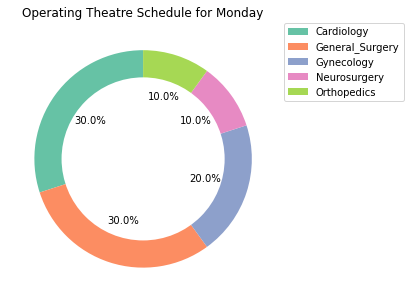

In [161]:
df_mon = grouped.get_group("Monday")

ax = df_mon.plot.pie(y='# OTs Allocated', figsize=(5, 5), autopct='%1.1f%%', startangle=90, legend=True, title='Operating Theatre Schedule for Monday', ylabel='',labeldistance=None, labels=label, colors = colors1)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
centre_circle = plot.Circle((0,0),0.750,fc='white')
fig = plot.gcf()
fig.gca().add_artist(centre_circle)
plot.show()

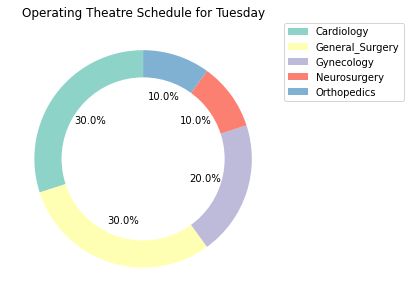

In [171]:
df_tues = grouped.get_group("Tuesday")

ax = df_mon.plot.pie(y='# OTs Allocated', figsize=(5, 5), autopct='%1.1f%%', startangle=90, legend=True, title='Operating Theatre Schedule for Tuesday', ylabel='',labeldistance=None, labels=label, colors = colors2)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
centre_circle = plot.Circle((0,0),0.750,fc='white')
fig = plot.gcf()
fig.gca().add_artist(centre_circle)
plot.show()

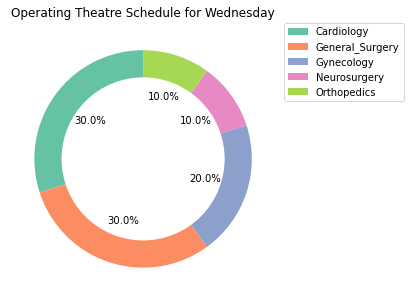

In [163]:
df_wed = grouped.get_group("Wednesday")

ax = df_mon.plot.pie(y='# OTs Allocated', figsize=(5, 5), autopct='%1.1f%%', startangle=90, legend=True, title='Operating Theatre Schedule for Wednesday', ylabel='',labeldistance=None, labels=label, colors = colors1)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
centre_circle = plot.Circle((0,0),0.750,fc='white')
fig = plot.gcf()
fig.gca().add_artist(centre_circle)
plot.show()

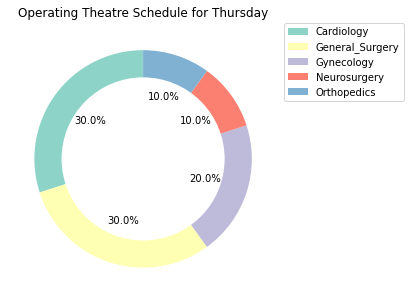

In [164]:
df_thurs = grouped.get_group("Thursday")

ax = df_mon.plot.pie(y='# OTs Allocated', figsize=(5, 5), autopct='%1.1f%%', startangle=90, legend=True, title='Operating Theatre Schedule for Thursday', ylabel='',labeldistance=None, labels=label, colors = colors2)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
centre_circle = plot.Circle((0,0),0.750,fc='white')
fig = plot.gcf()
fig.gca().add_artist(centre_circle)
plot.show()

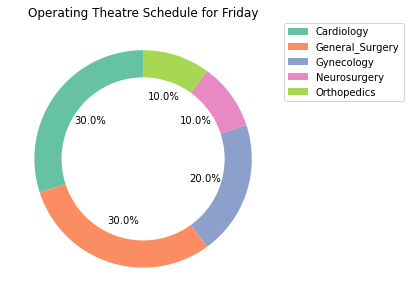

In [165]:
df_fri = grouped.get_group("Friday")

ax = df_mon.plot.pie(y='# OTs Allocated', figsize=(5, 5), autopct='%1.1f%%', startangle=90, legend=True, title='Operating Theatre Schedule for Friday', ylabel='',labeldistance=None, labels=label, colors = colors1)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
centre_circle = plot.Circle((0,0),0.750,fc='white')
fig = plot.gcf()
fig.gca().add_artist(centre_circle)
plot.show()